In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Parameter Efficient Fine Tuning with Gemini for Classification

## Overview

**Gemini** is a family of generative AI models developed by Google DeepMind that is designed for multimodal use cases. The Gemini API gives you access to the Gemini 1.0 Pro Vision and Gemini 1.0 Pro models.

This notebook demonstrates how to fine-tune the Gemini generative model using the Vertex AI Supervised Tuning feature. Supervised Tuning allows you to use your own training data to further refine the base model's capabilities towards your specific tasks.

Supervised Tuning uses labeled examples to tune a model. Each example demonstrates the output you want from your text model during inference.

First, ensure your training data is of high quality, well-labeled, and directly relevant to the target task. This is crucial as low-quality data can adversely affect the performance and introduce bias in the fine-tuned model.
- Training: Experiment with different configurations to optimize the model's performance on the target task.
- Evaluation:
  - Metric: Choose appropriate evaluation metrics that accurately reflect the success of the fine-tuned model for your specific task
  - Evaluation Set: Use a separate set of data to evaluate the model's performance

### Recommended configurations
The following table shows the recommended configurations for tuning a foundation model by task:

| Task           | No. of examples in dataset | Number of epochs |
| -------------- | -------------------------- | ----------- |
| Classification | 500+                       | 2-4         |
| Summarization  | 1000+                      | 2-4         |
| Extractive QA  | 500+                       | 2-4         |
| Chat           | 1000+                      | 2-4         |



<hr/>

Before running this notebook, ensure you have:

- A Google Cloud project: Provide your project ID in the `PROJECT_ID` variable.

- Authenticated your Colab environment: Run the authentication code block at the beginning.

- Prepared training data (Test with your own data or use the one in the notebook): Data should be formatted in JSONL with prompts and corresponding completions.


## Tuning Data Best Practices
When fine-tuning models, ensure your data is primed for success by focusing on

- Domain Alignment: Select training data that closely mirrors the specific domain and real-world scenarios of your intended application.
- Labeling Accuracy: Ensure meticulous and precise annotation of your training data to avoid misleading the model.
- Noise Reduction: Enhance the quality of your dataset by eliminating outliers, inconsistencies, or irrelevant data points.
- Distribution: Include diverse examples relevant to your target task, avoiding excessive variety that might lead to overgeneralization.
- Balanced Classes: For classification tasks, maintain a balanced representation of different classes to prevent the model from favoring a particular category.

## Medical Transcripts Dataset

To illustrate model fine-tuning, let’s  look at a classification problem using text data. We’ll use a medical transcription dataset and ask Gemini to classify a given transcript into one of 17 categories, e.g. 'Allergy/Immunology', 'Dentistry', 'Cardiovascular/ Pulmonary' etc. The dataset is from mtsamples.com as provided on [HuggingFace](https://huggingface.co/datasets/argilla/medical-domain). 

## Getting Started

### Install Vertex AI SDK and other required packages

In [ ]:
!pip3 install --upgrade --user --quiet google-cloud-aiplatform plotly datasets gcsfs fsspec evaluate scikit-learn

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

## Step0: Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

- If you are running this notebook in a local development environment:
  - Install the [Google Cloud SDK](https://cloud.google.com/sdk).
  - Obtain authentication credentials. Create local credentials by running the following command and following the oauth2 flow (read more about the command [here](https://cloud.google.com/sdk/gcloud/reference/beta/auth/application-default/login)):

    ```bash
    gcloud auth application-default login
    ```

## Step1: Import Libraries

In [1]:
import time
from typing import Dict, List
from ast import literal_eval

# For data handling.
import pandas as pd

# For visualization.
import matplotlib.pyplot as plt
import seaborn as sns

# For fine tuning Gemini model.
import vertexai

# For extracting vertex experiment details.
from google.cloud import aiplatform
from google.cloud.aiplatform.metadata import context
from google.cloud.aiplatform.metadata import utils as metadata_utils
from plotly.subplots import make_subplots

from datasets import load_dataset

# For evaluation metric computation.
from tqdm import tqdm
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
)
from vertexai.preview.tuning import sft

/opt/conda/envs/genai-gcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vertexai.__version__

'1.52.0'

## Step2: Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).


In [94]:
PROJECT_ID = "rthallam-demo-project"  # @param
LOCATION = "us-central1"  # @param

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Step3: Create Dataset in correct format

The dataset used to tune a foundation model needs to include examples that align with the task that you want the model to perform. Structure your training dataset in a text-to-text format. Each record, or row, in the dataset contains the input text (also referred to as the prompt) which is paired with its expected output from the model. Supervised tuning uses the dataset to teach the model to mimic a behavior, or task, you need by giving it hundreds of examples that illustrate that behavior.

Your dataset size depends on the task, and follows the recommendation mentioned in the `Overview` section. The more examples you provide in your dataset, the better the results.

### Dataset format

Training data should be structured within a JSONL file located at a Google Cloud Storage (GCS) URI. Each line (or row) of the JSONL file must adhere to a specific schema: It should contain a "messages" array, with objects inside defining a "role" (either "user" for user input or "model" for model output) and the corresponding text "content". For example, a valid data row would look like this:
```
{"messages": [{"role": "user", "content": <INPUT>}, {"role": "model", "content": <OUTPUT>}]}
```

To run a tuning job, you need to upload one or more datasets to a Cloud Storage bucket. You can either create a new Cloud Storage bucket or use an existing one to store dataset files. The region of the bucket doesn't matter, but we recommend that you use a bucket that's in the same Google Cloud project where you plan to tune your model.

### Step3 [a]: Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.


In [43]:
# Provide a bucket name
BUCKET_NAME = "rt-genai-on-gcp-book"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.


In [6]:
! gsutil mb -l {LOCATION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://rt-genai-on-gcp-book/...


### Step3 [b]: Download and prepare dataset from HuggingFace

In [22]:
from datasets import load_dataset, DatasetDict

HF_DATASET_NAME = "argilla/medical-domain"

dataset = load_dataset(HF_DATASET_NAME)
dataset = dataset['train'].train_test_split(test_size=0.3)
dataset.shape

{'train': (3476, 13), 'test': (1490, 13)}

In [129]:
dataset['train'][0]

{'text': 'S: , The patient presents for evaluation at the request of his primary physician for treatment for nails.  He has last seen the primary physician in December 2006.,PRIMARY MEDICAL HISTORY:,  Femoral embolectomy, GI bleed, hypertension, PVD, hypothyroid, GERD, osteoarthritis, diabetes, CAD, renal artery stenosis, COPD, and atrial fibrillation.,MEDICATIONS:,  Refer to chart.,O: , The patient presents in wheelchair, verbal and alert.  Vascular:  He has absent pedal pulses bilaterally.  Trophic changes include absent hair growth and dystrophic nails.  Skin texture is dry and shiny.  Skin color is rubor.  Classic findings include temperature change and edema +2.  Nails:  Thickened and hypertrophic, #1, #2, #3, #4, and #5 right and #1, #2, #3, #4, and #5 left.,A:,1.  Dystrophic nails.,2.  Peripheral vascular disease as per classic findings.,3.  Pain on palpation.,4.  Diabetes.,P:  ,Nails #1, #2, #3, #4, and #5 right and #1, #2, #3, #4, and #5 left were debrided.  The patient will b

In [18]:
# test_valid_dataset = dataset['test'].train_test_split(train_size=250)
# dataset = DatasetDict({
#     'train': dataset['train'],
#     'test': test_valid_dataset['test'],
#     'valid': test_valid_dataset['train']})

In [23]:
# create separate dataframe for train and test
df_train = pd.DataFrame(dataset['train'], columns=['text', 'prediction'])
# get value of label from prediction column in the dataframe which is a list of dictionaries
df_train['label'] = df_train['prediction'].apply(lambda x: literal_eval(str(x))[0]['label'].strip())
# drop column prediction in dataframe inplace
df_train.drop(['prediction'], axis=1, inplace=True)
# rename column names in dataframe
df_train.rename(columns={'text': 'input_text', 'label': 'output_text'}, inplace=True)
# Remove specialities with less than 50 examples 
data_categories  = df_train.groupby(df_train['output_text'])
df_train = data_categories.filter(lambda x:x.shape[0] > 50)
df_train.head()

,input_text,output_text
2,"DELIVERY NOTE: , On 12/23/08 at 0235 hours, a ...",Surgery
3,"PHYSICAL EXAMINATION,GENERAL: ,The patient is...",Consult - History and Phy.
4,"REASON FOR CONSULTATION:, Regarding weakness a...",Consult - History and Phy.
5,"REASON FOR CONSULTATION:, Newly diagnosed cho...",Hematology - Oncology
7,"1. Pelvic tumor.,2. Cystocele.,3. Rectocele...",Obstetrics / Gynecology


In [24]:
medical_specialities = list(df_train['output_text'].unique())
len(medical_specialities)

17

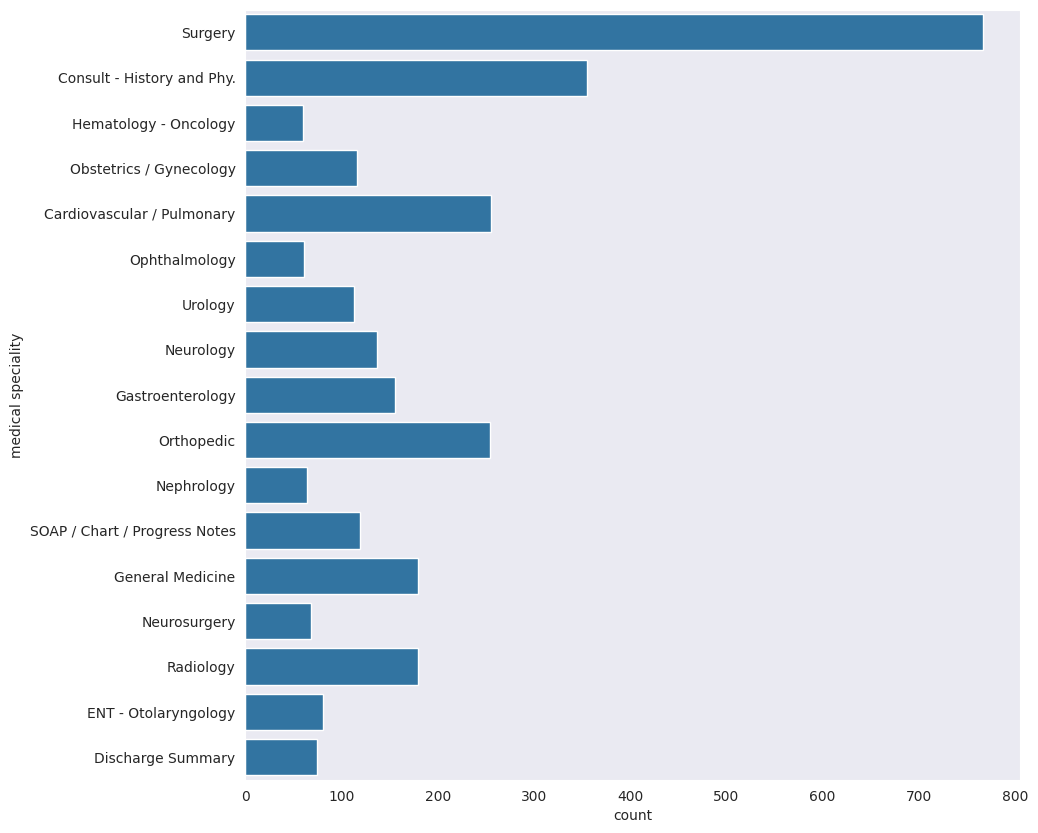

In [25]:
sns.set_style("dark")
sns.color_palette("dark")
plt.figure(figsize=(10,10))
ax = sns.countplot(y='output_text', data=df_train)
ax.set(xlabel='count', ylabel='medical speciality')
plt.show()

In [55]:
df_test = pd.DataFrame(dataset['test'], columns=['text', 'prediction'])
df_test['label'] = df_test['prediction'].apply(lambda x: literal_eval(str(x))[0]['label'].strip())
df_test.drop(['prediction'], axis=1, inplace=True)
df_test.rename(columns={'text': 'input_text', 'label': 'output_text'}, inplace=True)
df_test = df_test[df_test['output_text'].isin(medical_specialities)]

In [56]:
df_valid = df_test.groupby('output_text', as_index=False, group_keys=False)[["input_text", "output_text"]].apply(lambda x: x.sample(min(14, len(x)), random_state=43))
df_test = df_test[~df_test.index.isin(df_valid.index)]
print(df_valid.shape)
print(df_test.shape)

(238, 2)
(1061, 2)


In [57]:
system_instruction = """Identify the medical speciality from the <transcript>

You response must contain ONLY from ONE of following medical specialities with no explanations or reasoning.
{output_labels}
"""

prompt_template = """<transcript>
{input_text}
</transcript>

OUTPUT:"""


def convert_row_to_tuning_format(row, include_ground_truth=True):
    messages = [
        {"role": "system", "content": system_instruction.format(output_labels="\n".join(medical_specialities))},
        {"role": "user", "content": prompt_template.format(input_text=row["input_text"])}
    ]
    if include_ground_truth:
        messages.append({"role": "model", "content": row["output_text"]})
    return {"messages": messages}

In [58]:
df_train["tune_dataset"] = df_train.apply(convert_row_to_tuning_format, axis=1)
df_valid["tune_dataset"]  = df_valid.apply(convert_row_to_tuning_format, axis=1)
df_test["prompt"]  = df_test.apply(lambda row: convert_row_to_tuning_format(row, include_ground_truth=False), axis=1)
df_test.drop(['input_text'], inplace=True, axis=1)

In [59]:
df_train["tune_dataset"][:1].values[0]

{'messages': [{'role': 'system',
   'content': 'Identify the medical speciality from the <transcript>\n\nYou response must contain ONLY from ONE of following medical specialities with no explanations or reasoning.\nSurgery\nConsult - History and Phy.\nHematology - Oncology\nObstetrics / Gynecology\nCardiovascular / Pulmonary\nOphthalmology\nUrology\nNeurology\nGastroenterology\nOrthopedic\nNephrology\nSOAP / Chart / Progress Notes\nGeneral Medicine\nNeurosurgery\nRadiology\nENT - Otolaryngology\nDischarge Summary\n'},
  {'role': 'user',
   'content': '<transcript>\nDELIVERY NOTE: , On 12/23/08 at 0235 hours, a 23-year-old G1, P0, white female, GBS negative, under epidural anesthesia, delivered a viable female infant with Apgar scores of 7 and 9.  Points taken of for muscle tone and skin color.  Weight and length are unknown at this time.  Delivery was via spontaneous vaginal delivery.  Nuchal cord x1 were tight and reduced.  Infant was DeLee suctioned at perineum.  Cord clamped and cut

In [60]:
df_tune = df_train.groupby('output_text', as_index=False, group_keys=False)[["tune_dataset", "output_text"]].apply(lambda x: x.sample(min(50, len(x)), random_state=43)).reset_index(drop=True)
df_tune.head()

,tune_dataset,output_text
0,"{'messages': [{'role': 'system', 'content': 'I...",Cardiovascular / Pulmonary
1,"{'messages': [{'role': 'system', 'content': 'I...",Cardiovascular / Pulmonary
2,"{'messages': [{'role': 'system', 'content': 'I...",Cardiovascular / Pulmonary
3,"{'messages': [{'role': 'system', 'content': 'I...",Cardiovascular / Pulmonary
4,"{'messages': [{'role': 'system', 'content': 'I...",Cardiovascular / Pulmonary


In [61]:
df_tune.groupby(["output_text"]).size()

output_text
Cardiovascular / Pulmonary       50
Consult - History and Phy.       50
Discharge Summary                50
ENT - Otolaryngology             50
Gastroenterology                 50
General Medicine                 50
Hematology - Oncology            50
Nephrology                       50
Neurology                        50
Neurosurgery                     50
Obstetrics / Gynecology          50
Ophthalmology                    50
Orthopedic                       50
Radiology                        50
SOAP / Chart / Progress Notes    50
Surgery                          50
Urology                          50
dtype: int64

In [62]:
print(f"# of unique labels: {len(df_tune['output_text'].unique())}")
print(f"# of examples in training dataset: {df_tune.shape[0]}")
print(f"# of examples in validation dataset: {df_valid.shape[0]}")

# of unique labels: 17
# of examples in training dataset: 850
# of examples in validation dataset: 238


In [63]:
df_test.head()
# df_test.drop(['input_text'], inplace=True, axis=1)

,output_text,prompt
2,Radiology,"{'messages': [{'role': 'system', 'content': 'I..."
4,SOAP / Chart / Progress Notes,"{'messages': [{'role': 'system', 'content': 'I..."
5,SOAP / Chart / Progress Notes,"{'messages': [{'role': 'system', 'content': 'I..."
6,Surgery,"{'messages': [{'role': 'system', 'content': 'I..."
7,Surgery,"{'messages': [{'role': 'system', 'content': 'I..."


In [137]:
import json
json.dumps(df_tune.loc[0, "tune_dataset"])

'{"messages": [{"role": "system", "content": "Identify the medical speciality from the <transcript>\\n\\nYou response must contain ONLY from ONE of following medical specialities with no explanations or reasoning.\\nSurgery\\nConsult - History and Phy.\\nHematology - Oncology\\nObstetrics / Gynecology\\nCardiovascular / Pulmonary\\nOphthalmology\\nUrology\\nNeurology\\nGastroenterology\\nOrthopedic\\nNephrology\\nSOAP / Chart / Progress Notes\\nGeneral Medicine\\nNeurosurgery\\nRadiology\\nENT - Otolaryngology\\nDischarge Summary\\n"}, {"role": "user", "content": "<transcript>\\nPROCEDURE:, Flexible bronchoscopy.,PREOPERATIVE DIAGNOSIS (ES):, Chronic wheezing.,INDICATIONS FOR PROCEDURE:, Evaluate the airway.,DESCRIPTION OF PROCEDURE: ,This was done in the pediatric endoscopy suite with the aid of Anesthesia. The patient was sedated with sevoflurane and propofol. One mL of 1% lidocaine was used for airway anesthesia. The 2.8-mm flexible pediatric bronchoscope was passed through the left

### Step3 [b]: Upload tuning data to Cloud Storage

- Data used in this notebook is present in the public Google Cloud Storage(GCS) bucket.
- Validation data should be less than or equal to 250 samples.

In [64]:
TRAIN_PATH = f"{BUCKET_URI}/ch03/data/gemini-peft/train/train.jsonl"
df_tune["tune_dataset"].to_json(TRAIN_PATH, orient='records', lines=True)

In [65]:
VALID_PATH = f"{BUCKET_URI}/ch03/data/gemini-peft/valid/valid.jsonl"
df_valid["tune_dataset"].to_json(VALID_PATH, orient='records', lines=True)

In [66]:
TEST_PATH = f"{BUCKET_URI}/ch03/data/gemini-peft/test/test.jsonl"
df_test.to_json(TEST_PATH, orient='records', lines=True)

### Step3 [c]: Test dataset

- It contains document text(`input_text`) and corresponding reference summary(`output_text`), which will be compared with the model generated summary

In [67]:
# Load the test dataset using pandas
test_data = pd.read_json(TEST_PATH, lines=True).reset_index(drop=True)
test_data.loc[0, "prompt"]

{'messages': [{'role': 'system',
   'content': 'Identify the medical speciality from the <transcript>\n\nYou response must contain ONLY from ONE of following medical specialities with no explanations or reasoning.\nSurgery\nConsult - History and Phy.\nHematology - Oncology\nObstetrics / Gynecology\nCardiovascular / Pulmonary\nOphthalmology\nUrology\nNeurology\nGastroenterology\nOrthopedic\nNephrology\nSOAP / Chart / Progress Notes\nGeneral Medicine\nNeurosurgery\nRadiology\nENT - Otolaryngology\nDischarge Summary\n'},
  {'role': 'user',
   'content': '<transcript>\nCC:, Decreasing visual acuity.,HX: ,This 62 y/o RHF presented locally with a 2 month history of progressive loss of visual acuity, OD. She had a 2 year history of progressive loss of visual acuity, OS, and is now blind in that eye. She denied any other symptomatology. Denied HA.,PMH:, 1) depression. 2) Blind OS,MEDS:, None.,SHX/FHX: ,unremarkable for cancer, CAD, aneurysm, MS, stroke. No h/o Tobacco or ETOH use.,EXAM:, T36.0

## Step4: Load model

The following Gemini text models support supervised tuning:

* `gemini-1.0-pro-002`

In [68]:
generation_model = GenerativeModel("gemini-1.0-pro-002", 
                                   system_instruction=system_instruction.format(output_labels="\n".join(medical_specialities)))

## Step5: Test the Gemini model

### Generation config

- Each call that you send to a model includes parameter values that control how the model generates a response. The model can generate different results for different parameter values
- <strong>Experiment</strong> with different parameter values to get the best values for the task

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/adjust-parameter-values) for understanding different parameters

**Prompt** is a natural language request submitted to a language model to receive a response back

Some best practices include
  - Clearly communicate what content or information is most important
  - Structure the prompt:
    - Defining the role if using one. For example, You are an experienced UX designer at a top tech company
    - Include context and input data
    - Provide the instructions to the model
    - Add example(s) if you are using them

Refer to the following [link](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/prompts/prompt-design-strategies) for prompt design strategies.

Wikilingua data contains the following task prompt at the end of the article, `Provide a summary of the article in two or three sentences:`

In [72]:
test_doc = test_data.loc[0, "prompt"]
prompt = test_doc['messages'][1]['content']
print(prompt)

generation_config = GenerationConfig(temperature=0.1)

response = generation_model.generate_content(
    contents=prompt, 
    generation_config=generation_config
).text
print(response)

<transcript>
CC:, Decreasing visual acuity.,HX: ,This 62 y/o RHF presented locally with a 2 month history of progressive loss of visual acuity, OD. She had a 2 year history of progressive loss of visual acuity, OS, and is now blind in that eye. She denied any other symptomatology. Denied HA.,PMH:, 1) depression. 2) Blind OS,MEDS:, None.,SHX/FHX: ,unremarkable for cancer, CAD, aneurysm, MS, stroke. No h/o Tobacco or ETOH use.,EXAM:, T36.0, BP121/85, HR 94, RR16,MS: Alert and oriented to person, place and time. Speech fluent and unremarkable.,CN: Pale optic disks, OU. Visual acuity: 20/70 (OD) and able to detect only shadow of hand movement (OS). Pupils were pharmacologically dilated earlier. The rest of the CN exam was unremarkable.,MOTOR: 5/5 throughout with normal bulk and tone.,Sensory: no deficits to LT/PP/VIB/PROP.,Coord: FNF-RAM-HKS intact bilaterally.,Station: No pronator drift. Gait: ND,Reflexes: 3/3 BUE, 2/2 BLE. Plantar responses were flexor bilaterally.,Gen Exam: unremarkable

In [73]:
# Ground truth
test_data.loc[0, "output_text"]

'Radiology'

In [74]:
test_data['user_prompt'] = test_data['prompt'].apply(lambda row: row['messages'][1]['content'])
test_data

,output_text,prompt,user_prompt
0,Radiology,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nCC:, Decreasing visual acuity.,H..."
1,SOAP / Chart / Progress Notes,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nSUBJECTIVE:, The patient is an ..."
2,SOAP / Chart / Progress Notes,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nSUBJECTIVE: , Review of the medi..."
3,Surgery,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nPROCEDURES PERFORMED: , C5-C6 an..."
4,Surgery,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nPREOPERATIVE DIAGNOSIS:, Aortoi..."
...,...,...,...
1056,Radiology,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nREASON FOR EXAM:,1. Angina.,2. ..."
1057,General Medicine,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nMALE PHYSICAL EXAMINATION,HEENT:..."
1058,Surgery,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nPREOPERATIVE DIAGNOSIS: , T12 co..."
1059,General Medicine,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nGENERAL: ,XXX,VITAL SIGNS: , Bl..."


## Step6: Evaluation before model tuning

- Evaluate the Gemini model on the test dataset before tuning it on the training dataset.

In [75]:
# Convert the pandas dataframe to records (list of dictionaries).
corpus = test_data.to_dict(orient="records")
# Check number of records.
len(corpus)

1061

In [241]:
test_data.head()

,output_text,prompt
0,Neurology,"{'messages': [{'role': 'system', 'content': 'I..."
1,Gastroenterology,"{'messages': [{'role': 'system', 'content': 'I..."
2,Neurology,"{'messages': [{'role': 'system', 'content': 'I..."
3,SOAP / Chart / Progress Notes,"{'messages': [{'role': 'system', 'content': 'I..."
4,Discharge Summary,"{'messages': [{'role': 'system', 'content': 'I..."


### Evaluation metric

The type of metrics used for evaluation depends on the task that you are evaluating. The following table shows the supported tasks and the metrics used to evaluate each task:

| Task | Metric
|:---------|:--------:|
|  Classification   |  Micro-F1, Macro-F1, Per class F1   |
|  Summarization  |  ROUGE-L   |
|  Question Answering   |  Exact Match   |
|  Text Generation  | BLEU, ROUGE-L |


Refer to this [documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/models/evaluate-models) for metric based evaluation.

In [76]:
import evaluate

accuracy = evaluate.load("accuracy")

In [77]:
safety_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
}

generation_config = GenerationConfig(temperature=0.1)

In [117]:
def run_predict(prompt, model):
    try:
        response = model.generate_content(
            prompt,
            generation_config=generation_config,
            safety_settings=safety_settings
        )

        # Check if response is generated by the model, if response is empty then continue to next item.
        if not (
            response
            and response.candidates
            and response.candidates[0].content.parts
        ):
            print(
                f"\nModel has blocked the response for the document.\n  Response: {response}\n  Document: {document}"
            )
        return response.text
    except AttributeError as attr_err:
        print("Attribute Error:", attr_err)
    except Exception as err:
        print("Error:", err)

In [82]:
test_data["predicted_text"] = test_data["user_prompt"][:100].apply(lambda row: run_predict(row, generation_model)

In [83]:
y_pred = test_data["predicted_text"][:100].apply(lambda row: row.strip('\n'))
y_labels = test_data["output_text"][:100]

In [92]:
test_data[["output_text", "predicted_text"]]

,output_text,predicted_text
0,Radiology,Neurosurgery
1,SOAP / Chart / Progress Notes,General Medicine
2,SOAP / Chart / Progress Notes,Consult - History and Phy.
3,Surgery,Neurosurgery \n
4,Surgery,Surgery
...,...,...
1056,Radiology,NaN
1057,General Medicine,NaN
1058,Surgery,NaN
1059,General Medicine,NaN


In [84]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, y_pred, labels=medical_specialities))

                               precision    recall  f1-score   support

                      Surgery       0.70      0.20      0.31        35
   Consult - History and Phy.       0.00      0.00      0.00        12
        Hematology - Oncology       0.00      0.00      0.00         4
      Obstetrics / Gynecology       0.00      0.00      0.00         4
   Cardiovascular / Pulmonary       0.00      0.00      0.00         2
                Ophthalmology       0.00      0.00      0.00         1
                      Urology       0.50      0.20      0.29         5
                    Neurology       0.00      0.00      0.00         3
             Gastroenterology       1.00      0.25      0.40         4
                   Orthopedic       0.75      0.38      0.50         8
                   Nephrology       0.00      0.00      0.00         1
SOAP / Chart / Progress Notes       0.00      0.00      0.00         5
             General Medicine       0.00      0.00      0.00         6
     

/opt/conda/envs/genai-gcp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/genai-gcp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/envs/genai-gcp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/

In [143]:
eval_foundation = pd.DataFrame(classification_report(y_labels, y_pred, labels=medical_specialities, output_dict=True, zero_division=1.0)).transpose()
eval_foundation

,precision,recall,f1-score,support
Surgery,0.700000,0.200000,0.311111,35.0
Consult - History and Phy.,0.000000,0.000000,0.000000,12.0
Hematology - Oncology,1.000000,0.000000,0.000000,4.0
Obstetrics / Gynecology,0.000000,0.000000,0.000000,4.0
Cardiovascular / Pulmonary,0.000000,0.000000,0.000000,2.0
Ophthalmology,1.000000,0.000000,0.000000,1.0
Urology,0.500000,0.200000,0.285714,5.0
Neurology,0.000000,0.000000,0.000000,3.0
Gastroenterology,1.000000,0.250000,0.400000,4.0
Orthopedic,0.750000,0.375000,0.500000,8.0


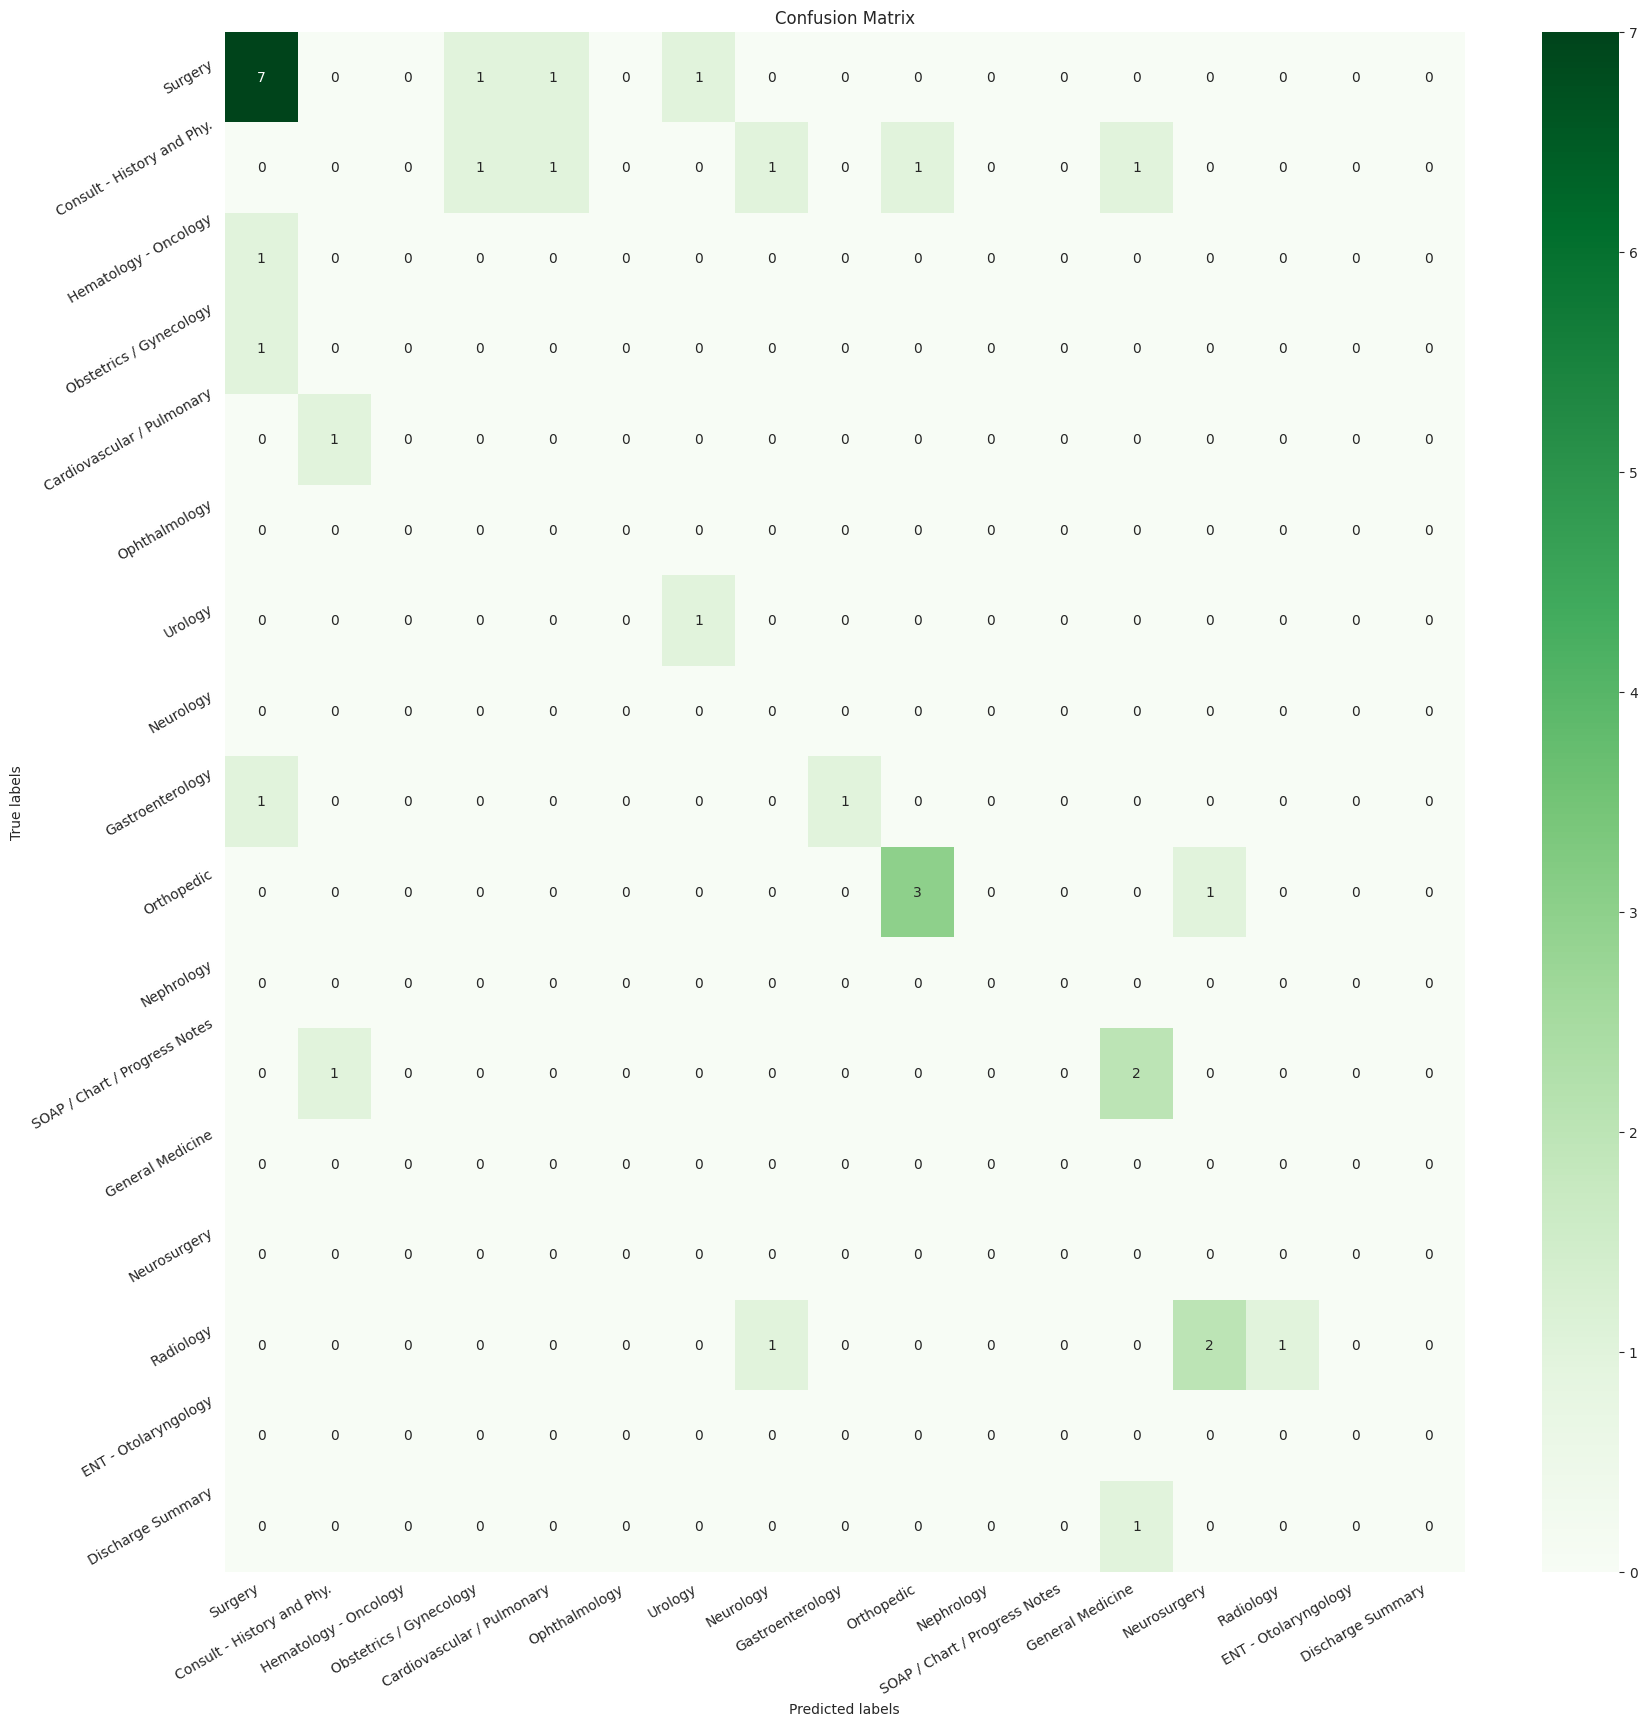

In [127]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_labels, y_pred, labels=medical_specialities)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(medical_specialities); ax.yaxis.set_ticklabels(medical_specialities);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

<strong>Alternate Evaluation method</strong>: Check out the [AutoSxS](https://cloud.google.com/vertex-ai/generative-ai/docs/models/side-by-side-eval) evaluation for automatic evaluation of the task.


## Step7: Fine-tune the Model

 - `source_model`: Specifies the base Gemini model version you want to fine-tune.
 - `train_dataset`: Path to your training data in JSONL format.

  *Optional parameters*
 - `validation_dataset`: If provided, this data is used to evaluate the model during tuning.
 - `epochs`: The number of training epochs to run.
 - `learning_rate_multiplier`: A value to scale the learning rate during training.

In [95]:
# Tune a model using `train` method.
sft_tuning_job = sft.train(
    source_model="gemini-1.0-pro-002",
    train_dataset=TRAIN_PATH,
    tuned_model_display_name="medical-transcript-classifier",
    # Optional:
    validation_dataset=VALID_PATH,
    epochs=3,
    learning_rate_multiplier=1,
    adapter_size=4
)

# Get the tuning job info.
sft_tuning_job.to_dict()

Creating SupervisedTuningJob
SupervisedTuningJob created. Resource name: projects/560224572293/locations/us-central1/tuningJobs/954451168937902080
To use this SupervisedTuningJob in another session:
tuning_job = sft.SupervisedTuningJob('projects/560224572293/locations/us-central1/tuningJobs/954451168937902080')
View Tuning Job:
https://console.cloud.google.com/vertex-ai/generative/language/locations/us-central1/tuning/tuningJob/954451168937902080?project=560224572293


{'name': 'projects/560224572293/locations/us-central1/tuningJobs/954451168937902080',
 'tunedModelDisplayName': 'medical-transcript-classifier',
 'baseModel': 'gemini-1.0-pro-002',
 'supervisedTuningSpec': {'trainingDatasetUri': 'gs://rt-genai-on-gcp-book/ch03/data/gemini-peft/train/train.jsonl',
  'validationDatasetUri': 'gs://rt-genai-on-gcp-book/ch03/data/gemini-peft/valid/valid.jsonl',
  'hyperParameters': {'epochCount': '3',
   'learningRateMultiplier': 1.0,
   'adapterSize': 'ADAPTER_SIZE_SIXTEEN'}},
 'state': 'JOB_STATE_PENDING',
 'createTime': '2024-05-27T14:51:50.294304Z',
 'updateTime': '2024-05-27T14:51:50.294304Z'}

In [96]:
# Get the resource name of the tuning job
sft_tuning_job_name = sft_tuning_job.resource_name
sft_tuning_job_name

'projects/560224572293/locations/us-central1/tuningJobs/954451168937902080'

**Note: Tuning time depends on several factors, such as training data size, number of epochs, learning rate multiplier, etc.**

<div class="alert alert-block alert-warning">
<b>⚠️ It will take around an hour for the model tuning job to complete on the provided dataset and set configurations/hyperparameters. ⚠️</b>
</div>

In [101]:
%%time
# Wait for job completion
while not sft_tuning_job.refresh().has_ended:
    time.sleep(60)

CPU times: user 62.1 ms, sys: 8.03 ms, total: 70.2 ms
Wall time: 432 ms


In [104]:
# tuned model name
tuned_model_name = sft_tuning_job.tuned_model_name
tuned_model_name

'projects/560224572293/locations/us-central1/models/2335803601558962176@1'

In [103]:
# tuned model endpoint name
tuned_model_endpoint_name = sft_tuning_job.tuned_model_endpoint_name
tuned_model_endpoint_name

'projects/560224572293/locations/us-central1/endpoints/4804274276125376512'

### Step7 [a]: Tuning and evaluation metrics

#### Model tuning metrics

- `/train_total_loss`: Loss for the tuning dataset at a training step.
- `/train_fraction_of_correct_next_step_preds`: The token accuracy at a training step. A single prediction consists of a sequence of tokens. This metric measures the accuracy of the predicted tokens when compared to the ground truth in the tuning dataset.
- `/train_num_predictions`: Number of predicted tokens at a training step

#### Model evaluation metrics:

- `/eval_total_loss`: Loss for the evaluation dataset at an evaluation step.
- `/eval_fraction_of_correct_next_step_preds`: The token accuracy at an evaluation step. A single prediction consists of a sequence of tokens. This metric measures the accuracy of the predicted tokens when compared to the ground truth in the evaluation dataset.
- `/eval_num_predictions`: Number of predicted tokens at an evaluation step.

The metrics visualizations are available after the model tuning job completes. If you don't specify a validation dataset when you create the tuning job, only the visualizations for the tuning metrics are available.


In [105]:
# Get resource name from tuning job.
experiment_name = sft_tuning_job.experiment.resource_name
experiment_name

'projects/560224572293/locations/us-central1/metadataStores/default/contexts/81e329c5-46c4-4f0f-abf0-16375a381ece'

In [106]:
# Locate Vertex Experiment and Vertex Experiment Run
experiment = aiplatform.Experiment(experiment_name=experiment_name)
filter_str = metadata_utils._make_filter_string(
    schema_title="system.ExperimentRun",
    parent_contexts=[experiment.resource_name],
)
experiment_run = context.Context.list(filter_str)[0]

In [107]:
# Read data from Tensorboard
tensorboard_run_name = f"{experiment.get_backing_tensorboard_resource().resource_name}/experiments/{experiment.name}/runs/{experiment_run.name}"
tensorboard_run = aiplatform.TensorboardRun(tensorboard_run_name)
metrics = tensorboard_run.read_time_series_data()

In [108]:
def get_metrics(metric: str = "/train_total_loss"):
    """
    Get metrics from Tensorboard.

    Args:
      metric: metric name, eg. /train_total_loss or /eval_total_loss.
    Returns:
      steps: list of steps.
      steps_loss: list of loss values.
    """
    loss_values = metrics[metric].values
    steps_loss = []
    steps = []
    for loss in loss_values:
        steps_loss.append(loss.scalar.value)
        steps.append(loss.step)
    return steps, steps_loss

In [109]:
# Get Train and Eval Loss
train_loss = get_metrics(metric="/train_total_loss")
eval_loss = get_metrics(metric="/eval_total_loss")

### Step7 [b]: Plot the metrics

In [116]:
# Plot the train and eval loss metrics using Plotly python library
import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=2, shared_xaxes=True, subplot_titles=("Train Loss", "Eval Loss")
)

# Add traces
fig.add_trace(
    go.Scatter(x=train_loss[0], y=train_loss[1], name="Train Loss", mode="lines"),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(x=eval_loss[0], y=eval_loss[1], name="Eval Loss", mode="lines"),
    row=1,
    col=2,
)

# Add figure title
fig.update_layout(title="Train and Eval Loss", xaxis_title="Steps", yaxis_title="Loss")

# Set x-axis title
fig.update_xaxes(title_text="Steps")

# Set y-axes titles
fig.update_yaxes(title_text="Loss")

# Show plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Step8: Load the Tuned Model

 - Load the fine-tuned model using `GenerativeModel` class with the tuning job model endpoint name.

 - Test the tuned model with the following prompt

In [113]:
prompt

'<transcript>\nCC:, Decreasing visual acuity.,HX: ,This 62 y/o RHF presented locally with a 2 month history of progressive loss of visual acuity, OD. She had a 2 year history of progressive loss of visual acuity, OS, and is now blind in that eye. She denied any other symptomatology. Denied HA.,PMH:, 1) depression. 2) Blind OS,MEDS:, None.,SHX/FHX: ,unremarkable for cancer, CAD, aneurysm, MS, stroke. No h/o Tobacco or ETOH use.,EXAM:, T36.0, BP121/85, HR 94, RR16,MS: Alert and oriented to person, place and time. Speech fluent and unremarkable.,CN: Pale optic disks, OU. Visual acuity: 20/70 (OD) and able to detect only shadow of hand movement (OS). Pupils were pharmacologically dilated earlier. The rest of the CN exam was unremarkable.,MOTOR: 5/5 throughout with normal bulk and tone.,Sensory: no deficits to LT/PP/VIB/PROP.,Coord: FNF-RAM-HKS intact bilaterally.,Station: No pronator drift. Gait: ND,Reflexes: 3/3 BUE, 2/2 BLE. Plantar responses were flexor bilaterally.,Gen Exam: unremarkab

In [115]:
if sft_tuning_job.has_succeeded:
    tuned_genai_model = GenerativeModel(tuned_model_endpoint_name, 
                                        system_instruction=system_instruction.format(output_labels="\n".join(medical_specialities)))
    # Test with the loaded model.
    print("***Testing***")
    print(tuned_genai_model.generate_content(contents=prompt).text)
else:
    print("State:", sft_tuning_job.state)
    print("Error:", sft_tuning_job.error)

***Testing***
Neurology


- We can clearly see the difference between summary generated pre and post tuning, as tuned summary is more inline with the ground truth format (**Note**: Pre and Post outputs, might vary based on the set parameters.)

  - *Pre*: `This article provides instructions on how to apply lotion to your back using your forearms. The method involves squeezing a line of lotion onto your forearms, bending your elbows, and reaching behind your back to rub the lotion on. The article also notes that this method may not be suitable for people with shoulder pain or limited flexibility. `
  - *Post*: `Dispense a line of lotion onto your forearms. Place your forearms behind you. Rub your forearms up and down your back.`
  - *Ground Truth*:` Squeeze a line of lotion onto the tops of both forearms and the backs of your hands. Place your arms behind your back. Move your arms in a windshield wiper motion.`

## Step9: Evaluation post model tuning

In [119]:
test_data["tuned_predicted_text"] = test_data["user_prompt"][:100].apply(lambda row: run_predict(row, tuned_genai_model))

In [120]:
test_data.head()

,output_text,prompt,user_prompt,predicted_text,tuned_predicted_text
0,Radiology,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nCC:, Decreasing visual acuity.,H...",Neurosurgery,Neurology
1,SOAP / Chart / Progress Notes,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nSUBJECTIVE:, The patient is an ...",General Medicine,General Medicine
2,SOAP / Chart / Progress Notes,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nSUBJECTIVE: , Review of the medi...",Consult - History and Phy.,SOAP / Chart / Progress Notes
3,Surgery,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nPROCEDURES PERFORMED: , C5-C6 an...",Neurosurgery \n,Neurosurgery
4,Surgery,"{'messages': [{'role': 'system', 'content': 'I...","<transcript>\nPREOPERATIVE DIAGNOSIS:, Aortoi...",Surgery,Cardiovascular / Pulmonary


In [121]:
y_tuned_pred = test_data["tuned_predicted_text"][:100].apply(lambda row: row.strip('\n'))
y_labels = test_data["output_text"][:100]

In [122]:
from sklearn.metrics import classification_report

print(classification_report(y_labels, y_tuned_pred, labels=medical_specialities))

                               precision    recall  f1-score   support

                      Surgery       1.00      0.06      0.11        35
   Consult - History and Phy.       0.80      0.33      0.47        12
        Hematology - Oncology       0.25      0.25      0.25         4
      Obstetrics / Gynecology       0.27      0.75      0.40         4
   Cardiovascular / Pulmonary       0.09      0.50      0.15         2
                Ophthalmology       0.33      1.00      0.50         1
                      Urology       0.50      1.00      0.67         5
                    Neurology       0.23      1.00      0.38         3
             Gastroenterology       0.67      1.00      0.80         4
                   Orthopedic       0.50      0.62      0.56         8
                   Nephrology       0.33      1.00      0.50         1
SOAP / Chart / Progress Notes       1.00      0.40      0.57         5
             General Medicine       0.50      0.33      0.40         6
     

/opt/conda/envs/genai-gcp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/conda/envs/genai-gcp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/conda/envs/genai-gcp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [144]:
eval_tuned = pd.DataFrame(classification_report(y_labels, y_tuned_pred, labels=medical_specialities, output_dict=True, zero_division=1.0)).transpose()
eval_tuned

,precision,recall,f1-score,support
Surgery,1.000000,0.057143,0.108108,35.00
Consult - History and Phy.,0.800000,0.333333,0.470588,12.00
Hematology - Oncology,0.250000,0.250000,0.250000,4.00
Obstetrics / Gynecology,0.272727,0.750000,0.400000,4.00
Cardiovascular / Pulmonary,0.090909,0.500000,0.153846,2.00
Ophthalmology,0.333333,1.000000,0.500000,1.00
Urology,0.500000,1.000000,0.666667,5.00
Neurology,0.230769,1.000000,0.375000,3.00
Gastroenterology,0.666667,1.000000,0.800000,4.00
Orthopedic,0.500000,0.625000,0.555556,8.00


In [150]:
perf_compare = eval_foundation.join(eval_tuned, lsuffix='_base', rsuffix='_tune')[['f1-score_base', 'f1-score_tune']]
perf_compare

,f1-score_base,f1-score_tune
Surgery,0.311111,0.108108
Consult - History and Phy.,0.000000,0.470588
Hematology - Oncology,0.000000,0.250000
Obstetrics / Gynecology,0.000000,0.400000
Cardiovascular / Pulmonary,0.000000,0.153846
Ophthalmology,0.000000,0.500000
Urology,0.285714,0.666667
Neurology,0.000000,0.375000
Gastroenterology,0.400000,0.800000
Orthopedic,0.500000,0.555556


In [151]:
perf_compare.to_csv('results.csv')

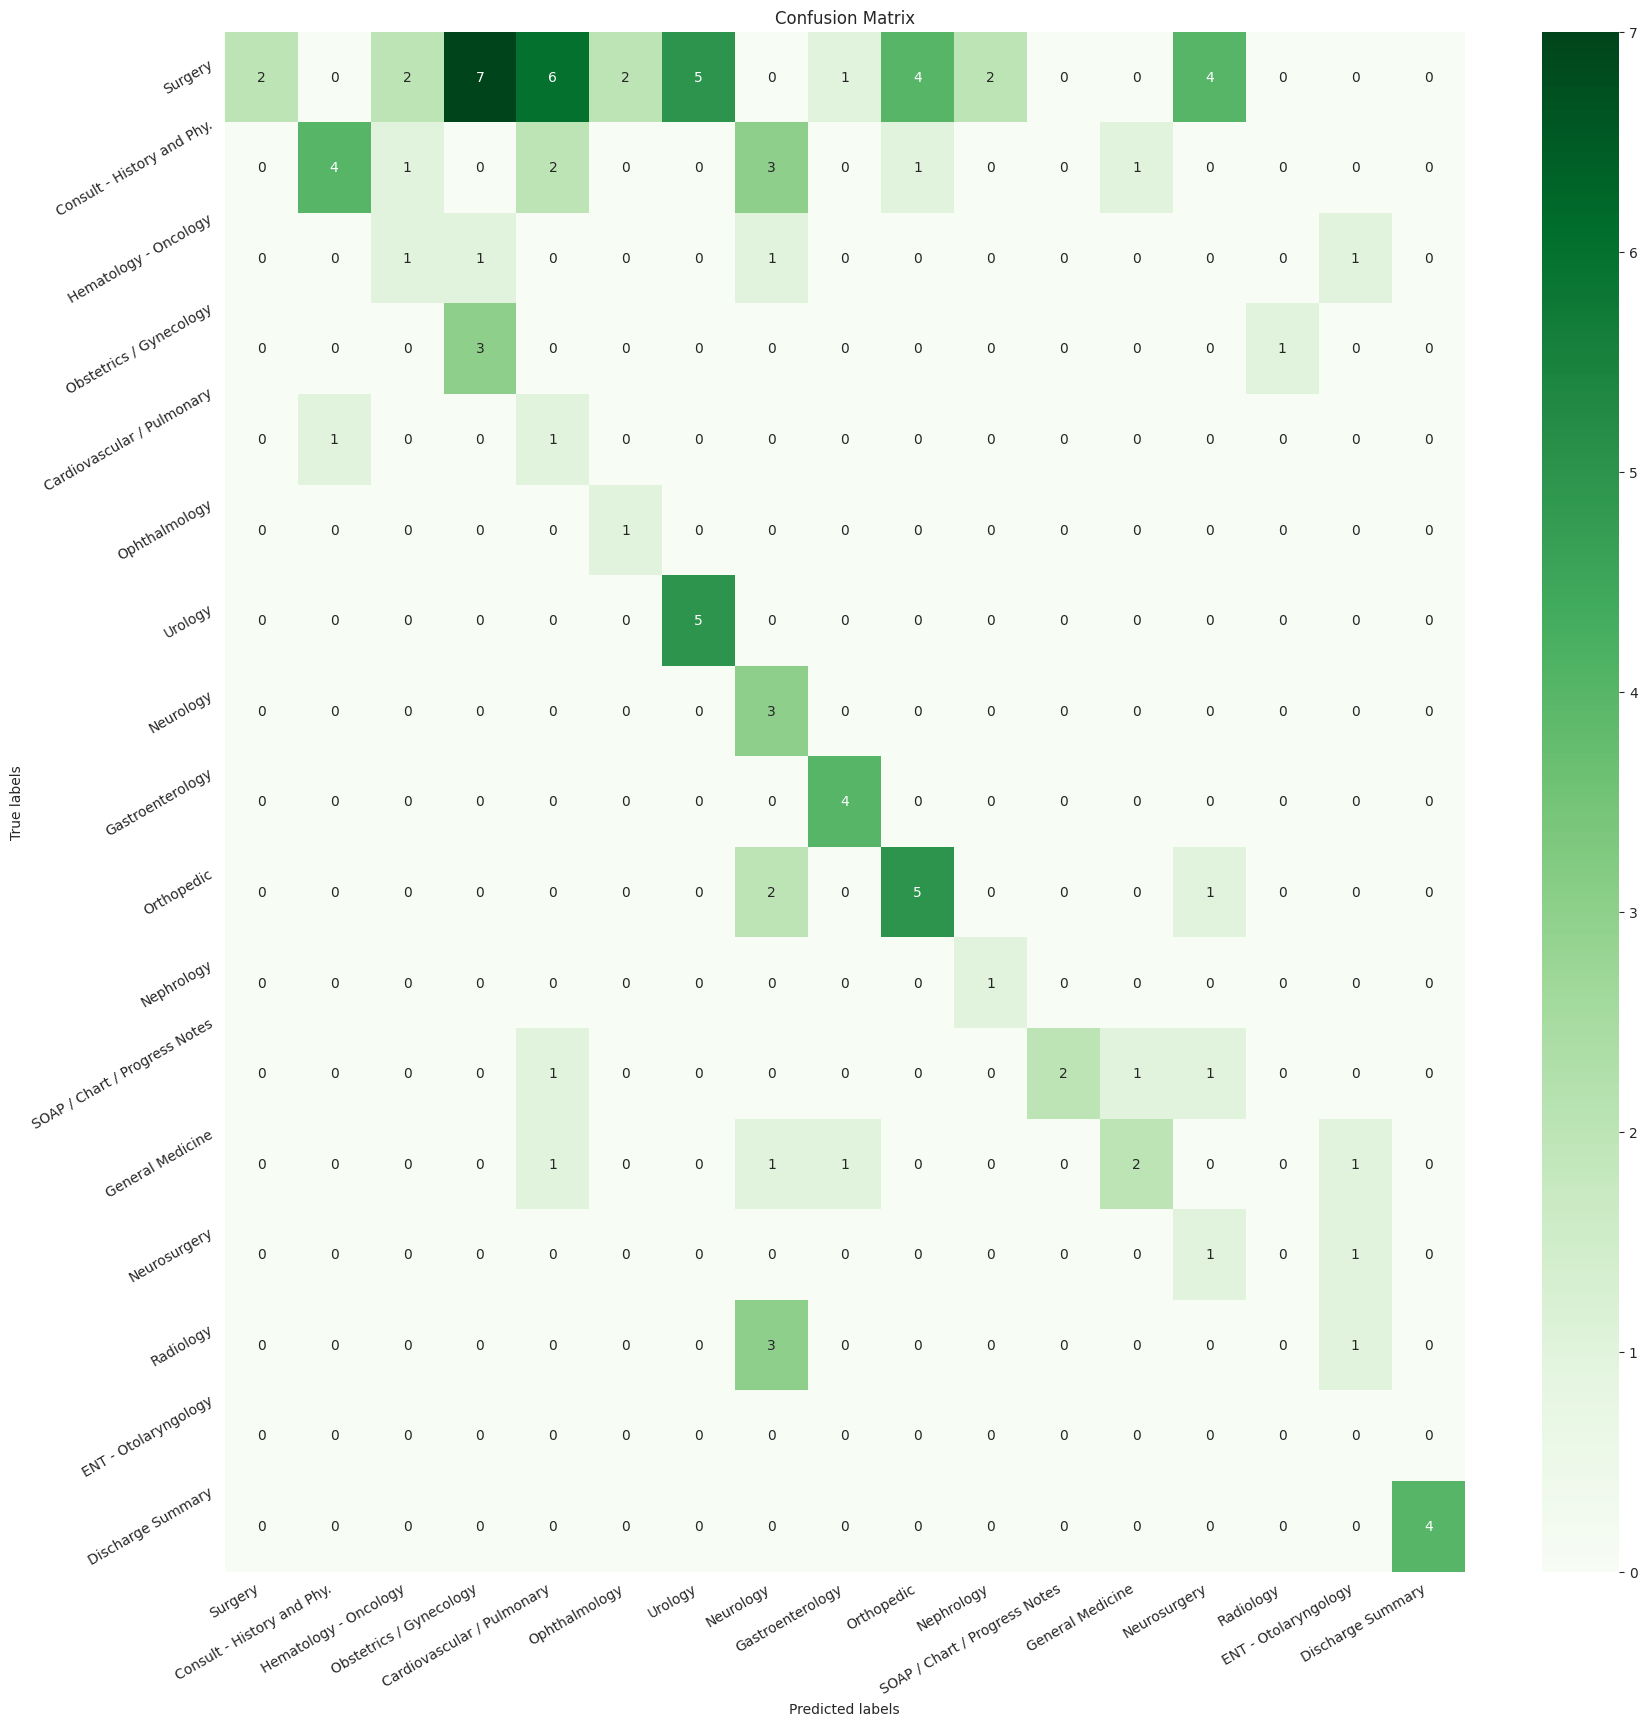

In [126]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_labels, y_tuned_pred, labels=medical_specialities)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(medical_specialities); ax.yaxis.set_ticklabels(medical_specialities);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

#### Improvement

In [ ]:
improvement = round(
    (
        (
            evaluation_df_post_tuning_stats.rougeL_precision["mean"]
            - evaluation_df_stats.rougeL_precision["mean"]
        )
        / evaluation_df_stats.rougeL_precision["mean"]
    )
    * 100,
    2,
)
print(
    f"Model tuning has improved the rougeL_precision by {improvement}% (result might differ based on each tuning iteration)"
)

## Conclusion

Performance could be further improved:
- By adding more training samples. In general, improve your training data quality and/or quantity towards getting a more diverse and comprehensive dataset for your task 
- By tuning the hyperparameters, such as epochs and learning rate multiplier
  - To find the optimal number of epochs for your dataset, we recommend experimenting with different values. While increasing epochs can lead to better performance, it's important to be mindful of overfitting, especially with smaller datasets. If you see signs of overfitting, reducing the number of epochs can help mitigate the issue
- You may try different prompt structures/formats and opt for the one with better performance

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.


Otherwise, you can delete the individual resources you created in this tutorial.

Refer to this [instructions](https://cloud.google.com/vertex-ai/docs/tutorials/image-classification-custom/cleanup#delete_resources) to delete the resources from console.

In [ ]:
# Delete Experiment.
delete_experiments = True
if delete_experiments:
    experiments_list = aiplatform.Experiment.list()
    for experiment in experiments_list:
        if experiment.resource_name == experiment_name:
            print(experiment.resource_name)
            experiment.delete()
            break

print("***" * 10)

# Delete Endpoint.
delete_endpoint = True
# If force is set to True, all deployed models on this
# Endpoint will be first undeployed.
if delete_endpoint:
    for endpoint in aiplatform.Endpoint.list():
        if endpoint.resource_name == tuned_model_endpoint_name:
            print(endpoint.resource_name)
            endpoint.delete(force=True)
            break

print("***" * 10)

# Delete Model.
delete_model = True
if delete_model:
    # Remove version from model name.
    tuned_model_name = tuned_model_name.split("@")[0]
    for model in aiplatform.Model.list():
        if model.resource_name == tuned_model_name:
            print(model.resource_name)
            model.delete()
            break

print("***" * 10)

# Delete Cloud Storage Bucket.
delete_bucket = True
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI